# Installations + Imports

In [1]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 805.2/805.2 kB 11.1 MB/s eta 0:00:00


In [5]:
import math
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

from google.colab import files
from tqdm.auto import tqdm
from torchmetrics import MeanAbsolutePercentageError
from datetime import datetime

# Classes + Helpers

## Data preprocessing

In [65]:
def plot_autocorr(series, lags):
  autocorr = []
  for lag in range(lags):
    autocorr.append(series.autocorr(lag=lag))

  autocorr = np.array(autocorr)

  plt.figure(figsize=(30, 10))
  plt.plot(autocorr)
  plt.show()

In [66]:
def scale_data(data_df,
               start_train_date,
               end_val_date,
               start_test_date,
               end_test_date):

  train_val_df = data_df[(data_df.index >= start_train_date) &
                        (data_df.index <= end_val_date)]
  test_df = data_df[(data_df.index >= start_test_date) &
                    (data_df.index <= end_test_date)]

  scaler = MinMaxScaler()
  train_val_scaled = scaler.fit_transform(train_val_df)
  train_val_df_scaled = pd.DataFrame(train_val_scaled,
                                    columns=train_val_df.columns,
                                    index=train_val_df.index)
  test_scaled = scaler.transform(test_df)
  test_df_scaled = pd.DataFrame(test_scaled,
                                columns=test_df.columns,
                                index=test_df.index)

  data_df_scaled = pd.concat([train_val_df_scaled, test_df_scaled], axis=0)

  return data_df_scaled, scaler

In [67]:
def reframe_series(series: pd.Series,
                   n_lags: int,
                   horizon: int,
                   skip_steps: int = 0,
                   is_target: bool = False):

  assert isinstance(series, pd.Series)

  if series.name is None:
    name = 'Series'
  else:
    name = series.name

  past_window_iter = list(range(-n_lags+1, 1, 1))

  if is_target:
    future_window_start = skip_steps + 1
    future_window_end = future_window_start + horizon
    future_window_iter = list(range(future_window_start, future_window_end, 1))

    window_iter = past_window_iter + future_window_iter
  else:
    window_iter = past_window_iter

  df_list = [series.shift(-i) for i in window_iter]
  df = pd.concat(df_list, axis=1)
  df.columns = [f'{name}(t-{np.abs(j)})' if j <= 0
                else f'{name}(t+{j})'
                for j in window_iter]

  df.columns = [re.sub('t-0', 't', x) for x in df.columns]

  return df


def reframe_dataframe(data_df: pd.DataFrame,
                      n_lags: int,
                      horizon: int,
                      skip_steps: int = 0):

  # transforming each variable into a matrix format
  mat_by_var = []
  for col in data_df:
    if col == TARGET:
      reframed_series_df = reframe_series(data_df[col], n_lags=n_lags, horizon=horizon, skip_steps=skip_steps, is_target=True)
    else:
      reframed_series_df = reframe_series(data_df[col], n_lags=n_lags, horizon=horizon, skip_steps=skip_steps, is_target=False)
    mat_by_var.append(reframed_series_df)

  # concatenating all variables
  reframed_df = pd.concat(mat_by_var, axis=1).dropna()

  # defining target (Y) and explanatory variables (X)
  predictor_vars = reframed_df.columns.str.contains('\(t\-|\(t\)')
  target_vars = reframed_df.columns.str.contains('\(t\+')
  X_df = reframed_df.iloc[:, predictor_vars]
  Y_df = reframed_df.iloc[:, target_vars]

  return X_df, Y_df


def from_2d_to_3d(df: pd.DataFrame, orig_var_names: List[str]) -> np.ndarray:
  """
  Transforming a time series from matrix into 3-d structure for deep learning
  :param df: (pd.DataFrame) Time series in the matrix format after embedding

  :return: Reshaped time series into 3-d structure
  """
  cols = df.columns
  D = len(orig_var_names)

  var_names = np.unique([re.sub(r'\([^)]*\)', '', c) for c in cols]).tolist()

  if (np.unique(np.array(var_names)) == np.unique(np.array(orig_var_names))).sum() != D:
    print(f"The unique column names contained in the 'var_names' variable are not the same as the original column names!")
    return
  else:
    arr_by_var = [df.loc[:, cols.str.contains(var)].values for var in orig_var_names]
    arr_by_var = [x.reshape(x.shape[0], x.shape[1], 1) for x in arr_by_var]

    arr_3d = np.concatenate(arr_by_var, axis=2)
    print(arr_3d.shape)

    return arr_3d


def from_3d_to_2d(arr: np.ndarray,
                  col_names: pd.Index,
                  index: pd.DatetimeIndex):

    if arr.shape[2] > 1:
        arr_split = np.dsplit(arr, arr.shape[2])
    else:
        arr_split = [arr]

    arr_reshaped = [x.reshape(x.shape[0], x.shape[1]) for x in arr_split]

    df = pd.concat([pd.DataFrame(x) for x in arr_reshaped], axis=1)
    df.columns = col_names
    df.index = index

    return df

In [68]:
def split_data(X_df, Y_df,
               start_train_date,
               end_train_date,
               start_val_date,
               end_val_date,
               start_test_date,
               end_test_date):

  X_train_df = X_df[(X_df.index >= start_train_date) & (X_df.index <= end_train_date)]
  Y_train_df = Y_df[(X_df.index >= start_train_date) & (Y_df.index <= end_train_date)]

  X_val_df = X_df[(X_df.index >= start_val_date) & (X_df.index <= end_val_date)]
  Y_val_df = Y_df[(Y_df.index >= start_val_date) & (Y_df.index <= end_val_date)]

  X_test_df = X_df[(X_df.index >= start_test_date) & (X_df.index <= end_test_date)]
  Y_test_df = Y_df[(Y_df.index >= start_test_date) & (Y_df.index <= end_test_date)]

  return X_train_df, X_val_df, X_test_df, Y_train_df, Y_val_df, Y_test_df

In [69]:
class LoadDataset(Dataset):
  def __init__(self, X_3D, y_df):
    self.X = torch.tensor(X_3D, dtype=torch.float32)
    self.y = torch.tensor(y_df.values, dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

## Transformer - Encoder

In [70]:
class MultiHeadAttention(nn.Module):
  def __init__(self, d_k, d_model, n_heads):
    super().__init__()

    # Assume d_v = d_k
    self.d_k = d_k
    self.n_heads = n_heads

    self.key = nn.Linear(d_model, d_k * n_heads)
    self.query = nn.Linear(d_model, d_k * n_heads)
    self.value = nn.Linear(d_model, d_k * n_heads)

    # final linear layer
    self.fc = nn.Linear(d_k * n_heads, d_model)

  def forward(self, q, k, v, mask=None):
    # h -> Number of attention heads
    q = self.query(q)   # [N, T, d_model] --> [N, T, h*d_k]
    k = self.key(k)     # [N, T, d_model] --> [N, T, h*d_k]
    v = self.value(v)   # [N, T, d_model] --> [N, T, h*d_v]

    N = q.shape[0]    # batch size
    T = q.shape[1]    # sequence length

    # make the following change in shape:
    # [N, T, h, d_k (or d_v)] --> [N, h, T, d_k (or d_v)]
    # in order for multiplication to work properly
    q = q.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
    k = k.view(N, T, self.n_heads, self.d_k).transpose(1, 2)
    v = v.view(N, T, self.n_heads, self.d_k).transpose(1, 2)

    # compute attention weights
    # [N, h, T, d_k] x [N, h, d_k, T] --> [N, h, T, T]
    attention_scores = q @ k.transpose(-2, -1) / math.sqrt(self.d_k)
    if mask is not None:
      attention_scores = attention_scores.masked_fill(
          mask[:, None, None, :] == 0, float('-inf')
      )
    attention_weights = F.softmax(attention_scores, dim=-1)

    # compute attention-weighted values
    # [N, h, T, T] x [N, h, T, d_k] --> [N, h, T, d_k]
    A = attention_weights @ v

    # reshape it back before final linear layer
    A = A.transpose(1, 2)   # [N, T, h, d_k]
    A = A.contiguous().view(N, T, self.d_k * self.n_heads)    # [N, T, h*d_k]

    # projection
    return self.fc(A)

In [71]:
class TransformerBlock(nn.Module):
  def __init__(self, d_k, d_model, n_heads, dropout_prob=0.1):
    super().__init__()

    self.ln1 = nn.LayerNorm(d_model)
    self.ln2 = nn.LayerNorm(d_model)
    self.mha = MultiHeadAttention(d_k, d_model, n_heads)
    self.ann = nn.Sequential(
        nn.Linear(d_model, 4 * d_model),
        nn.GELU(),
        nn.Linear(4 * d_model, d_model),
        nn.GELU(),
        nn.Dropout(p=dropout_prob),
    )
    self.dropout = nn.Dropout(p=dropout_prob)

  def forward(self, x, mask=None):
    x = self.ln1(x + self.mha(x, x, x, mask))
    x = self.ln2(x + self.ann(x))
    x = self.dropout(x)
    return x

In [72]:
class PositionalEncoding(nn.Module):
  def __init__(self, d_model, max_len=1024, dropout_prob=0.1):
    super().__init__()
    self.dropout = nn.Dropout(p=dropout_prob)

    position = torch.arange(max_len).unsqueeze(1)
    exp_term = torch.arange(0, d_model, 2)
    div_term = torch.exp(exp_term * (-math.log(10000.0) / d_model))
    pe = torch.zeros(1, max_len, d_model)
    pe[0, :, 0::2] = torch.sin(position * div_term)
    pe[0, :, 1::2] = torch.cos(position * div_term)
    self.register_buffer('pe', pe)

  def forward(self, x):
    # x --> [N, T, D]
    x = x + self.pe[:, :x.size(1), :]
    return self.dropout(x)

In [73]:
class Encoder(nn.Module):
  def __init__(self,
               D,
               max_len,
               d_k,
               d_model,
               n_heads,
               n_layers,
               output_units,
               dropout_prob):
    super().__init__()

    # self.conv1d = nn.Conv1d(in_channels=D,
    #                         out_channels=d_model,
    #                         kernel_size=1)
    self.linear = nn.Linear(D, d_model)
    self.relu = nn.ReLU()
    self.pos_encoding = PositionalEncoding(d_model,
                                           max_len,
                                           dropout_prob)
    transformer_blocks = [
        TransformerBlock(
            d_k,
            d_model,
            n_heads,
            dropout_prob) for _ in range(n_layers)]
    self.transformer_blocks = nn.Sequential(*transformer_blocks)
    self.ln = nn.LayerNorm(d_model)
    self.fc = nn.Linear(d_model, output_units)

  def forward(self, x, mask=None):
    # x = self.conv1d(x).transpose(1, 2)
    x = self.relu(self.linear(x))
    x = self.pos_encoding(x)
    for block in self.transformer_blocks:
      x = block(x, mask)

    # many-to-one (x --> [N, T, D])
    x = x[:, 0, :]

    x = self.ln(x)
    x = self.fc(x)
    return x

## Training and Evaluation

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
loss_fn = MeanAbsolutePercentageError().to(device)

# def mape(y_preds, y_true):
#   epsilon = 1.17e-06
#   abs_diff = torch.abs(y_preds - y_true)
#   abs_per_error = abs_diff / torch.clamp(torch.abs(y_true), min=epsilon)
#   mape = torch.sum(abs_per_error) / y_true.numel()

#   return mape

# def loss_fn(y_preds, y_true, device):
#   MAPE = mape(y_preds, y_true)
#   loss = MAPE * (1 + 0.4 * torch.max(torch.tensor([0, MAPE - 2])))
#   return loss.to(device).requires_grad_(True)


def train_step(model,
               dataloader,
               optimizer,
               device,):

  model.train()
  loss = 0
  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    y_preds = model(X).squeeze().to(device)
    batch_loss = loss_fn(y_preds, y)
    loss += batch_loss.item()
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()

  loss /= len(dataloader)
  return loss

def val_step(model, dataloader, device):
  model.eval()
  val_loss = 0
  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)
      val_preds = model(X).squeeze().to(device)

      y_preds_unscaled = scaler.data_min_[TARGET_POS] + val_preds * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])
      y_true_unscaled  = scaler.data_min_[TARGET_POS] + y * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

      batch_loss = torch.tensor(100) * loss_fn(y_preds_unscaled, y_true_unscaled)
      val_loss += batch_loss.item()

  val_loss /= len(dataloader)
  return val_loss

def train(model,
          train_dataloader,
          val_dataloader,
          optimizer,
          epochs,
          patience,
          device,
          scheduler,
          path):

  results = {
      "loss": [],
      "val_loss": []
  }

  for epoch in tqdm(range(epochs)):
    flag = 0
    loss = train_step(model=model,
                      dataloader=train_dataloader,
                      optimizer=optimizer,
                      device=device,)

    val_loss = val_step(model=model,
                        dataloader=val_dataloader,
                        device=device)

    scheduler.step(val_loss)

    results['loss'].append(loss)
    results['val_loss'].append(val_loss)
    if epoch == 0:
      best_val_loss = val_loss
      best_epoch = -1
      checkpoint(model, optimizer, path)
      flag = 1
      print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss:.4f} | Val loss: {val_loss:.4f} - *Checkpoint*")
    else:
      if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
        checkpoint(model, optimizer, path)
        flag = 1
        print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss:.4f} | Val loss: {val_loss:.4f} - *Checkpoint*")
      elif epoch - best_epoch > patience:
        print(f"\nEarly stopping applied at epoch {epoch}.")
        break
    if flag == 0:
      print(f"Epoch: {epoch+1}/{epochs} | Loss: {loss:.4f} | Val loss: {val_loss:.4f}")

  return results

def checkpoint(model, optimizer, filepath):
  torch.save({
    "optimizer": optimizer.state_dict(),
    "model": model.state_dict()
  }, filepath)

# MAIN

In [63]:
TARGET = "TOTAL_CONS"
N_LAGS = 24
HORIZON = 24
SKIP_STEPS = 10 * 24

# keep 1 year for testing
START_TEST_DATE = pd.to_datetime('2018-01-01') - pd.to_timedelta(SKIP_STEPS + HORIZON, 'h')
END_TEST_DATE = START_TEST_DATE + pd.DateOffset(years=1)

END_VAL_DATE = START_TEST_DATE - pd.to_timedelta(1, 'h')
START_VAL_DATE = pd.to_datetime('2017-01-01') - pd.to_timedelta(SKIP_STEPS + HORIZON, 'h')

START_TRAIN_DATE = pd.to_datetime('2015-01-01')
END_TRAIN_DATE = START_VAL_DATE - pd.to_timedelta(1, 'h')

TARGET = "TOTAL_CONS"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 2048

print(f"Train:      {START_TRAIN_DATE} - {END_TRAIN_DATE}")
print(f"Validation: {START_VAL_DATE} - {END_VAL_DATE}")
print(f"Test:       {START_TEST_DATE} - {END_TEST_DATE}")

Train:      2015-01-01 00:00:00 - 2016-12-20 23:00:00
Validation: 2016-12-21 00:00:00 - 2017-12-20 23:00:00
Test:       2017-12-21 00:00:00 - 2018-12-21 00:00:00


In [64]:
# Read the data
data_df = pd.read_csv("/content/FINAL_DATASET_2.csv")
data_df.set_index(pd.to_datetime(data_df["Timestamp"]), inplace=True)
data_df.drop("Timestamp", axis=1, inplace=True)

# Scale the data
data_df_scaled, scaler = scale_data(data_df,
                                    START_TRAIN_DATE,
                                    END_VAL_DATE,
                                    START_TEST_DATE,
                                    END_TEST_DATE)

# Shift future Time and Weather related variables (I assume that we know the weather...)
time_weather_cols = data_df_scaled.drop(TARGET, axis=1).columns
time_weather_df = data_df_scaled[time_weather_cols].shift(-SKIP_STEPS - HORIZON)
target_df = data_df_scaled[TARGET]
data_df_scaled = pd.concat((target_df, time_weather_df), axis=1)
data_df_scaled.dropna(inplace=True)

TARGET_POS = np.where(data_df_scaled.columns == TARGET)[0][0]
ORIG_VAR_NAMES = list(data_df_scaled.columns)

# Reframe the data
X_df, Y_df = reframe_dataframe(data_df_scaled, N_LAGS, HORIZON, SKIP_STEPS)

# Split the data
X_train_df, X_val_df, X_test_df, Y_train_df, Y_val_df, Y_test_df = split_data(X_df, Y_df,
                                                                              START_TRAIN_DATE,
                                                                              END_TRAIN_DATE,
                                                                              START_VAL_DATE,
                                                                              END_VAL_DATE,
                                                                              START_TEST_DATE,
                                                                              END_TEST_DATE)

# Turn Dataframes into 3D arrays
X_train_3d = from_2d_to_3d(X_train_df, ORIG_VAR_NAMES)
X_val_3d = from_2d_to_3d(X_val_df, ORIG_VAR_NAMES)
X_test_3d = from_2d_to_3d(X_test_df, ORIG_VAR_NAMES)

# Create Dataloaders
train_dataset = LoadDataset(X_3D=X_train_3d, y_df=Y_train_df)
train_dataloader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = LoadDataset(X_3D=X_val_3d, y_df=Y_val_df)
val_dataloader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE)

(17257, 24, 8)
(8760, 24, 8)
(8233, 24, 8)


# Training

In [75]:
EPOCHS = 2000
PATIENCE = 50
PATH = "model.pth"

model = Encoder(D=X_train_3d.shape[2],
                max_len=N_LAGS,
                d_k=16,
                d_model=64,
                n_heads=16,
                n_layers=3,
                output_units=24,
                dropout_prob=0).to(DEVICE)

optimizer = torch.optim.Adam(params=model.parameters(),
                             lr=1e-3,
                             weight_decay=0)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.33, patience=20, verbose=True)

In [76]:
!rm -rf "model.pth"
start_time = datetime.now()

model_results = train(model=model,
                      train_dataloader=train_dataloader,
                      val_dataloader=val_dataloader,
                      optimizer=optimizer,
                      epochs=EPOCHS,
                      patience=PATIENCE,
                      device=device,
                      scheduler=scheduler,
                      path=PATH)

total_time = datetime.now() - start_time
print(f"Total training time: {total_time.seconds}")

  0%|          | 0/2000 [00:00<?, ?it/s]

Epoch: 1/2000 | Loss: 0.6891 | Val loss: 17.4767 - *Checkpoint*
Epoch: 2/2000 | Loss: 0.4509 | Val loss: 15.8274 - *Checkpoint*
Epoch: 3/2000 | Loss: 0.4266 | Val loss: 15.3848 - *Checkpoint*
Epoch: 4/2000 | Loss: 0.4186 | Val loss: 15.1923 - *Checkpoint*
Epoch: 5/2000 | Loss: 0.4140 | Val loss: 15.0449 - *Checkpoint*
Epoch: 6/2000 | Loss: 0.4089 | Val loss: 14.8244 - *Checkpoint*
Epoch: 7/2000 | Loss: 0.4028 | Val loss: 14.5536 - *Checkpoint*
Epoch: 8/2000 | Loss: 0.3850 | Val loss: 13.8451 - *Checkpoint*
Epoch: 9/2000 | Loss: 0.3405 | Val loss: 13.2355 - *Checkpoint*
Epoch: 10/2000 | Loss: 0.3003 | Val loss: 11.8472 - *Checkpoint*
Epoch: 11/2000 | Loss: 0.2627 | Val loss: 10.9613 - *Checkpoint*
Epoch: 12/2000 | Loss: 0.2430 | Val loss: 10.4041 - *Checkpoint*
Epoch: 13/2000 | Loss: 0.2380 | Val loss: 9.5127 - *Checkpoint*
Epoch: 14/2000 | Loss: 0.2088 | Val loss: 8.6800 - *Checkpoint*
Epoch: 15/2000 | Loss: 0.1943 | Val loss: 8.3858 - *Checkpoint*
Epoch: 16/2000 | Loss: 0.1868 | Val l

In [80]:
model_results.keys()

dict_keys(['loss', 'val_loss'])

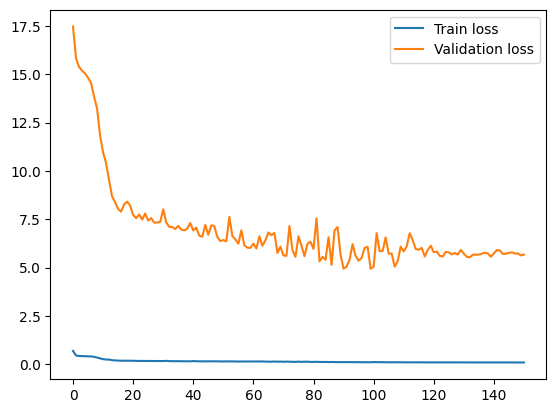

In [81]:
plt.figure()
plt.plot(model_results['loss'], label='Train loss')
plt.plot(model_results['val_loss'], label='Validation loss')
plt.legend()
plt.show()

# Inference + results

In [77]:
checkpoint = torch.load("model.pth")
model.load_state_dict(checkpoint['model'])
optimizer.load_state_dict(checkpoint['optimizer'])
# model.to("cpu")
model.eval()
with torch.inference_mode():
  test_preds_scaled = model(torch.tensor(X_test_3d, dtype=torch.float32, device=device))
test_preds_scaled = test_preds_scaled.to('cpu').squeeze().numpy()

test_preds_df_scaled = pd.DataFrame(test_preds_scaled, columns=np.arange(1, HORIZON+1), index=Y_test_df.index)
test_preds_df = pd.DataFrame(columns=np.arange(1, HORIZON+1), index=test_preds_df_scaled.index)
for i, col in enumerate(test_preds_df_scaled.columns):
  test_preds_df[i+1] = scaler.data_min_[TARGET_POS] + test_preds_df_scaled[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

real_df = pd.DataFrame(columns=np.arange(1, HORIZON+1), index=test_preds_df.index)
for i, col in enumerate(Y_test_df.columns):
  real_df[i+1] = scaler.data_min_[TARGET_POS] + Y_test_df[col].to_numpy() * (scaler.data_max_[TARGET_POS] - scaler.data_min_[TARGET_POS])

In [78]:
mape_list = list()
step_results_dict = {}
for step in range(1, HORIZON + 1):
  step_index = real_df.index + pd.to_timedelta(SKIP_STEPS + step, 'h')
  step_results_df = pd.DataFrame(
      {
          "real": real_df.loc[:, step].to_numpy(),
          "predictions": test_preds_df.loc[:, step].to_numpy()
      },
      index=step_index
  )
  step_results_df['abs_error'] = abs(step_results_df['real'] - step_results_df['predictions'])
  step_results_df['ape'] = np.where(step_results_df['real'] == 0, np.NaN, 100 * step_results_df['abs_error']/step_results_df['real'])
  step_mape = step_results_df['ape'].mean()
  mape_list.append(step_mape)
  print(f"Step {step} -> MAPE = {step_mape}")

  step_results_dict[step] = step_results_df
mape = np.array(mape_list).mean()
print(f"\nMAPE = {mape}")

Step 1 -> MAPE = 7.251128577978127
Step 2 -> MAPE = 6.970148094031559
Step 3 -> MAPE = 7.010939169866067
Step 4 -> MAPE = 7.075445662301432
Step 5 -> MAPE = 6.352555060236333
Step 6 -> MAPE = 6.294893709878758
Step 7 -> MAPE = 6.080966199991199
Step 8 -> MAPE = 6.295845636300029
Step 9 -> MAPE = 6.075947008941556
Step 10 -> MAPE = 6.478711641547863
Step 11 -> MAPE = 6.4491631245223955
Step 12 -> MAPE = 7.193383988733495
Step 13 -> MAPE = 7.392464228678949
Step 14 -> MAPE = 6.715731592147533
Step 15 -> MAPE = 6.737062372785533
Step 16 -> MAPE = 5.984252338428159
Step 17 -> MAPE = 5.817365607932986
Step 18 -> MAPE = 6.061021121062629
Step 19 -> MAPE = 6.436035032960653
Step 20 -> MAPE = 6.046159156723261
Step 21 -> MAPE = 7.0959257715810224
Step 22 -> MAPE = 6.5418808722628965
Step 23 -> MAPE = 6.415364063607383
Step 24 -> MAPE = 7.1086461570051185

MAPE = 6.578376507896039
